# Data integration



Personal view

> In a narrow biological mindset, data integration involves having multiple datasets, either at a single omics level or a multi-omics stack, and extracting a piece of information that is holistic in nature. The way to achive this is by understanding model/feature representation from complex data sets and by designing algorithms for knowledge transfer. In a wider industry circle, a lot of the drive in the area comes from recommender systems (an equivalent in biology would be to pick the right genes from a set of samples, or the right sample from a set of genes, unfortunately the biological research is a backward water in this case, largely due to the p-value obsession driving the publishing industry).

Classes of methods:

- Unsupervised:
    - Puting datasets together in a larger matrix, then running an unsupervised clustering method.
    - Computing pairwise similarities and using graph clustering techniques
    - Using a dimension reduction technique (autoencoder, canonical PLS or CCA to reduce the dimensionalities to a common subspace)
    - A mix of the above, and also finding ways to integrate with expert knowledge.
- Supervised:
    - Traditional regression and clustering algorithms
    - Deep CNNs, GANs.
    - Better bang for the buck, solid p-values too, possibility of missing the point.
- Hybrid approaches:
    - Ensemble learning, variational autoencoders, graphical methods

# Unsupervised clustering

We have a final day task in data integration, for now we will use a dimension reduction technique that uses linear decompositions to formulate a subspace of maxinal co-variation between two datasets. First let us formulate a test dataset which is a very useful exercise that can allow you to make your method more robust and tune parameters.

In [1]:
import numpy as np

# features
n = 500

# latents variables:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)
l3 = np.random.normal(size=n)
l4 = np.random.normal(size=n)

latent_X = np.array([l1, l1, l2, l2, l2, l3]).T
latent_Y = np.array([l2, l3, l4, l4]).T
X = 0.50*latent_X + 0.50*np.random.normal(size=6 * n).reshape((n, 6))
Y = 0.50*latent_Y + 0.50*np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

Corr(X)
[[ 1.    0.51 -0.05 -0.   -0.03  0.02]
 [ 0.51  1.    0.02  0.02 -0.   -0.05]
 [-0.05  0.02  1.    0.48  0.59 -0.05]
 [-0.    0.02  0.48  1.    0.51 -0.02]
 [-0.03 -0.    0.59  0.51  1.   -0.07]
 [ 0.02 -0.05 -0.05 -0.02 -0.07  1.  ]]
Corr(Y)
[[ 1.   -0.03 -0.02  0.  ]
 [-0.03  1.    0.03  0.04]
 [-0.02  0.03  1.    0.5 ]
 [ 0.    0.04  0.5   1.  ]]


# Cannonical correlation analysis

Many clustering algorithms would now fail because we have only one common dimension (number of features, you can thing for example in terms of genes or samples). More-over, the biological signal is obscured by different latent variables tht can be sources of biological and technical noise. CCA 

Canonical-correlation analysis seeks linear combinations of X and Y that have maximum correlation to each other. The technique is inductive, the first pair of components has scores that capture the most variation, and the second pair is orthogonal (uncorelated) to the first, etc. We can visualize this with a couple of plots.

In [2]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

In [3]:
print(X_train_r.shape, Y_train_r.shape)

(250, 2) (250, 2)


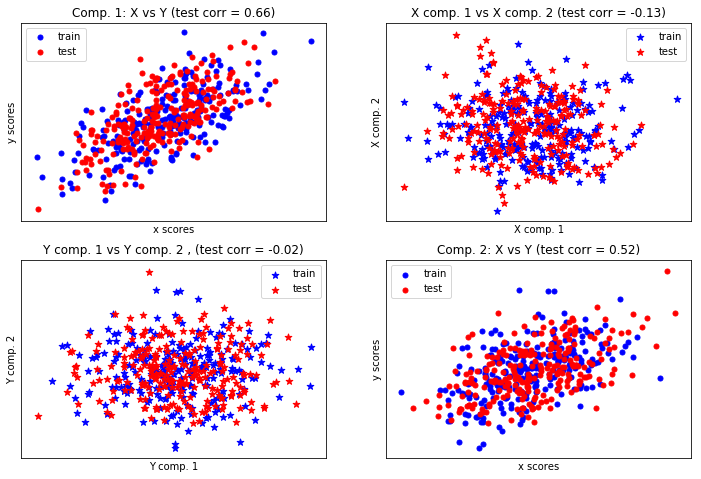

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()


Task:
- Verify that the components are orthogonal.
- Tweak the number and coefficients of the initial datasets to have larger or smaller shared latent co-variation.
- Select a few features having high joint variation and a few features showing low joint variation. Plot them in the original space.
- Apply cannonical PLS instead of CCA and see if there is an improvement. Profit!